In [1]:
import pandas as pd
import numpy as np
import glob
import os.path
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from project_utils import weak_wn_acf
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from scipy.stats import probplot, norm, t, nct, skewnorm, kstest
from statsmodels.graphics.tsaplots import plot_acf
import probscale

plt.rcParams["figure.figsize"] = (16,8)

stock_files = glob.glob('data/stock/stock*.txt')
dfs = {}
for file_n in stock_files:
    df = pd.read_csv(file_n)['x']
    df_name = os.path.split(file_n)[-1].split('.')[0]
    df_name
    dfs[df_name] = df

df = pd.concat(dfs, axis=1)

## Visual Check for Trend and Heteroscedasticity
The following code produces plots of returns, rolling mean, and rolling standard deviation. From the rolling mean it looks like the mean is constant implying the absence of trend. The rolling standard deviation seems to vary for some of the stocks. These checks are formalized in the next section with tests for autocorrelation.

In [5]:
n=list(range(40)) # run this cell once

0


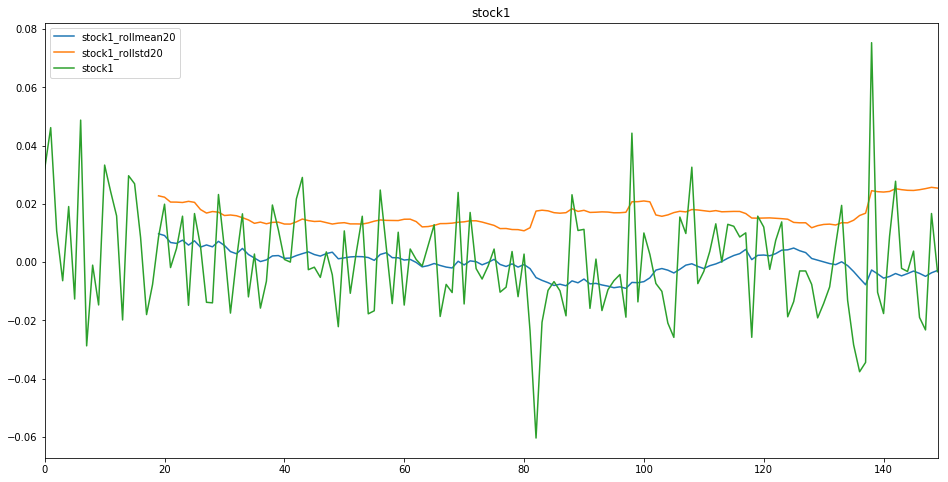

In [6]:
# run this cell to see the results for the next stock.
# ctrl-enter is a good hotkey for repeatedly running the same cell.
m = n.pop(0)
print(m)
ret = df.iloc[:,m]
window  = 20
roll_means = df.iloc[:,m].rolling(window).mean()
roll_means.name += '_rollmean'  +str(window)
roll_std = ret.rolling(window).std()
roll_std.name += '_rollstd' + str(window)
roll_means.columns = ['roll1', 'roll2', 'roll3']

ax = roll_means.plot()
ax = roll_std.plot(ax=ax)
ax = ret.plot(title=ret.name,ax=ax)
ax.legend()
plt.show()

# Check for autocorrelation and ARCH effects.
The following code produces autocorrelation plots for the returns and squared returns. It also produces the results of Engle’s Test for ARCH effects. The autocorrelation plots show that autocorrelation is not present and that autocorrelation of squared returns may be present for some stocks. ARCH effects were found to be present in stock2, stock27, stock32, stock37, and stock7.

In [8]:
n=list(range(40)) # Run this cell once

No Arch effects detected for stock28
0.9723131475629261
Ljung-Box pvals up to lag 30: [0.45677664 0.52563804 0.73238347 0.71936823 0.72918539 0.52069731
 0.52043917 0.60211189 0.41673678 0.50842708 0.5387419  0.60389772
 0.67938836 0.74734667 0.75236419 0.80902805 0.7902416  0.81551347
 0.777937   0.81953914 0.85807238 0.85791433 0.87395343 0.89505829
 0.90081029 0.92288685 0.93971891 0.9270747  0.93785476 0.94429102]


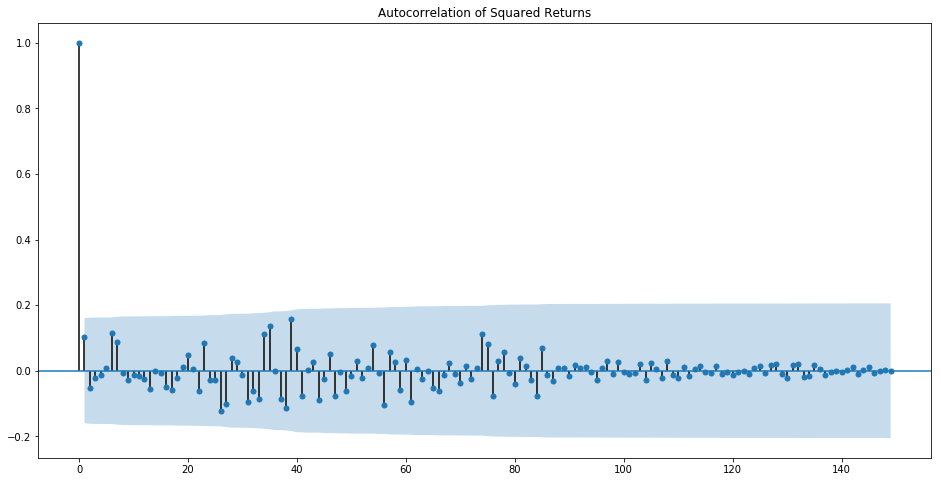

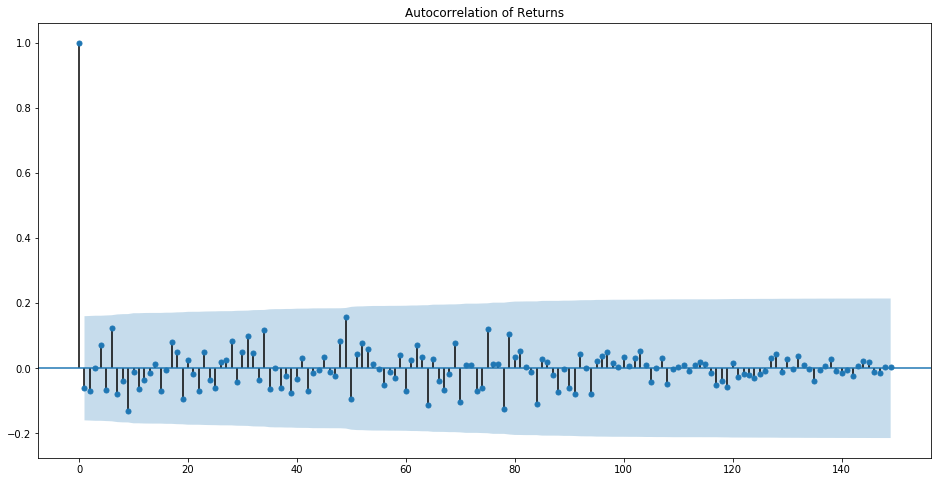

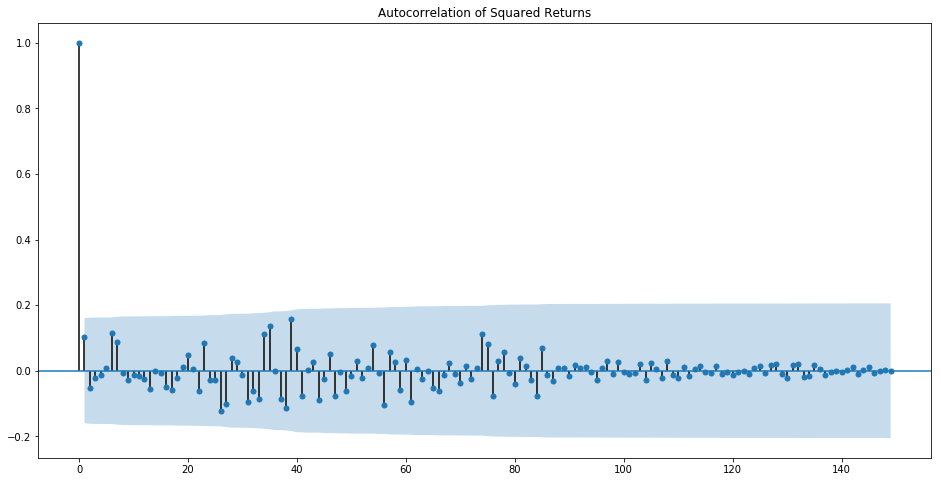

In [26]:
# run this cell to see the results for the next stock.
# ctrl-enter is a good hotkey for repeatedly running the same cell.
m=n.pop(0)
ret = df.iloc[:,m]
pval = het_arch(ret, maxlag =30)[1]



if pval <= 0.1:
    print('Arch effects present for ' + ret.name)
else:
    print('No Arch effects detected for ' + ret.name)
print(pval)

pval = acorr_ljungbox(ret, 30)[1]

print("Ljung-Box pvals up to lag 30: " + str(pval))

ret = df.iloc[:,m]
ret = ret - ret.mean()
plot_acf(ret, title='Autocorrelation of Returns')

plot_acf(ret**2, title='Autocorrelation of Squared Returns')

# Models
Based on the above it makes sense to model stock2, stock27, stock32, stock37, and stock7 with constan mean GARCH and the rest of the stocks with strong white noise. The strong white noise fit and forecasting results are presented below. The GARCH fits and forecasts will be presented in an R notebook because R has better packages for working with GARCH models.

In [23]:
GARCH_stocks = ['stock2', 'stock27', 'stock32', 'stock37', 'stock7']
wn_stocks = df.columns[~df.columns.isin(GARCH_stocks)]
n = list(range(40))

The pvalue of the Kolmogorov-Smirnov test for a normal distribution is 0.0048619748314122635
The pvalue of the Kolmogorov-Smirnov test for a student-t distribution is 0.9642118187419467
The pvalue of the Kolmogorov-Smirnov test for a non-central student-t distribution is 0.8690263277885729
The pvalue of the Kolmogorov-Smirnov test for a skewnorm distribution is 0.01754222021916907


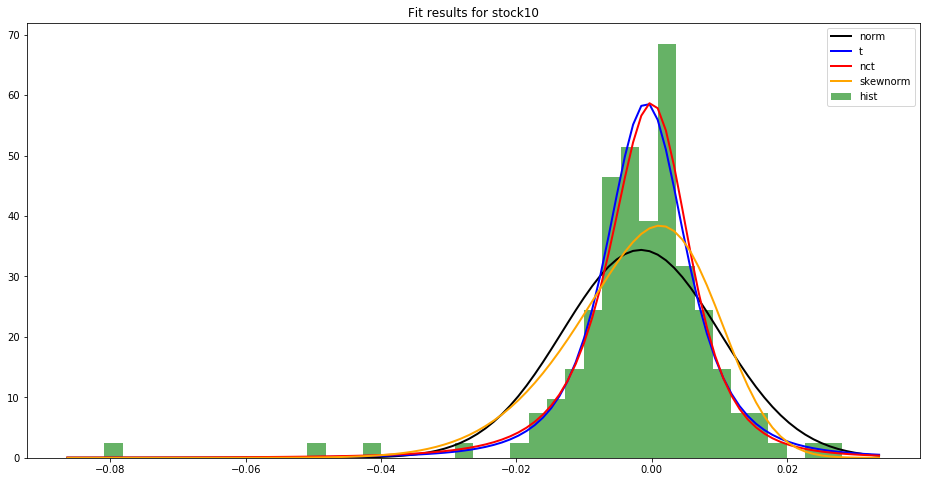

<Figure size 1152x576 with 0 Axes>

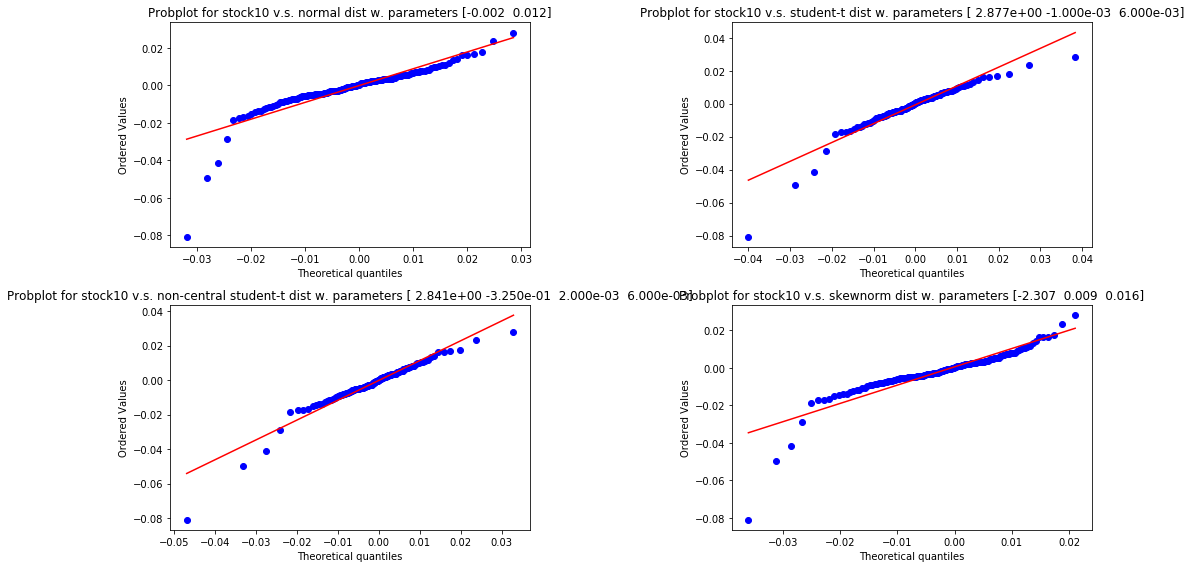

In [25]:
m = n.pop(0)

ret = df[wn_stocks[m]]

plt.figure(0)
# Plot the histogram.
plt.hist(ret, density=True, bins=40, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

norm_fit = norm.fit(ret)
p = norm.pdf(x, *norm_fit)
plt.plot(x, p, 'k', linewidth=2)

t_fit = t.fit(ret)
p = t.pdf(x, *t_fit)
plt.plot(x, p, 'b', linewidth=2)

nct_fit = nct.fit(ret)
p = nct.pdf(x, *nct_fit)
plt.plot(x, p, 'r', linewidth=2)

skewnorm_fit = skewnorm.fit(ret)
p = skewnorm.pdf(x, *skewnorm_fit)
plt.plot(x, p, 'orange', linewidth=2)



title = "Fit results for " + ret.name
plt.title(title)
plt.legend(['norm','t', 'nct', 'skewnorm', 'hist'])
plt.figure(1)
fig, ax = plt.subplots(2,2)

probplot(ret, plot=ax[0,0], dist='norm', sparams=norm_fit)
ax[0,0].set_title("Probplot for " + ret.name+  " v.s. normal dist w. parameters " + str( np.round(norm_fit, 3)))

probplot(ret, plot=ax[0,1], dist='t', sparams=t_fit);
ax[0,1].set_title("Probplot for " + ret.name+  " v.s. student-t dist w. parameters " + str(np.round(t_fit, 3)))

probplot(ret, plot=ax[1,0], dist='nct', sparams=nct_fit);
ax[1,0].set_title("Probplot for " + ret.name+  " v.s. non-central student-t dist w. parameters " + str(np.round(nct_fit, 3)))

probplot(ret, plot=ax[1,1], dist='skewnorm', sparams=skewnorm_fit);
ax[1,1].set_title("Probplot for " + ret.name+  " v.s. skewnorm dist w. parameters " + str(np.round(skewnorm_fit, 3)))


norm_test = kstest(ret, 'norm', args=norm_fit)
t_test  = kstest(ret, 't', args=t_fit)
nct_test = kstest(ret, 'nct', args=nct_fit)
skewnorm_test = kstest(ret, 'skewnorm', args=skewnorm_fit)
print("The pvalue of the Kolmogorov-Smirnov test for a normal distribution is " + str(norm_test[1]))
print("The pvalue of the Kolmogorov-Smirnov test for a student-t distribution is " + str(t_test[1]))
print("The pvalue of the Kolmogorov-Smirnov test for a non-central student-t distribution is " + str(nct_test[1]))
print("The pvalue of the Kolmogorov-Smirnov test for a skewnorm distribution is " + str(skewnorm_test[1]))

plt.tight_layout()

C:\Users\Travis\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
C:\Users\Travis\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)
C:\Users\Travis\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Travis\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Travis\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
C:\Users\Travis\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margin

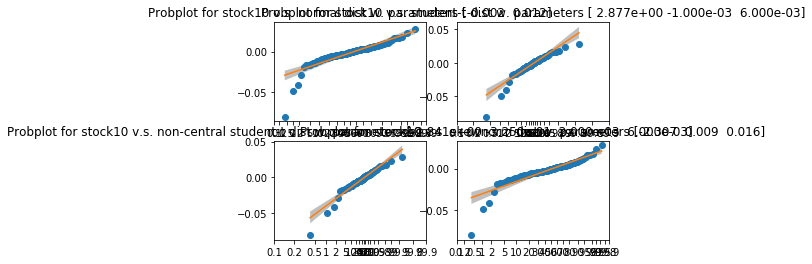

In [8]:
# Prob plots with bootstraped conficence intervals. THIS CODE IS SLOW.
m = n.pop(0)

ret = df[wn_stocks[m]]

norm_fit = norm.fit(ret)

t_fit = t.fit(ret)

nct_fit = nct.fit(ret)

skewnorm_fit = skewnorm.fit(ret)

fig, ax = plt.subplots(2,2)

probscale.probplot(ret, ax=ax[0,0],dist=norm(*norm_fit), bestfit=True, estimate_ci=True
                  )
ax[0,0].set_title("Probplot for " + ret.name+  " v.s. normal dist w. parameters " + str( np.round(norm_fit, 3)))
#ax[0,0].legend()

probscale.probplot(ret, ax=ax[0,1], dist=t(*t_fit), bestfit=True, estimate_ci=True
                  )
ax[0,1].set_title("Probplot for " + ret.name+  " v.s. student-t dist w. parameters " + str(np.round(t_fit, 3)))
#ax[0,1].legend()

probscale.probplot(ret, ax=ax[1,0], dist=nct(*nct_fit), bestfit=True, estimate_ci=True
                  )
ax[1,0].set_title("Probplot for " + ret.name+  " v.s. non-central student-t dist w. parameters " + str(np.round(nct_fit, 3)))
#ax[1,0].legend()

probscale.probplot(ret, ax=ax[1,1], dist=skewnorm(*skewnorm_fit), bestfit=True, estimate_ci=True
                  )
ax[1,1].set_title("Probplot for " + ret.name+  " v.s. skewnorm dist w. parameters " + str(np.round(skewnorm_fit, 3)))
#ax[1,1].legend()

plt.tight_layout()

## Forecasts
It looks like non-central student-t fits the best overall. The code below generages 15% lower quantiles with estimated distributions. The lower quantiles don't differ much across distributions as differences in skew and kurtosis are the most apparent at the extremes and 15% is still quite high for a lower quantile. Knowing this I generate my forcasts using the non-central student-t distribution.


In [26]:
n=list(range(40)) # Run this cell once

(0.11333333333333333,
 0.14666666666666667,
 0.14666666666666667,
 0.11333333333333333)

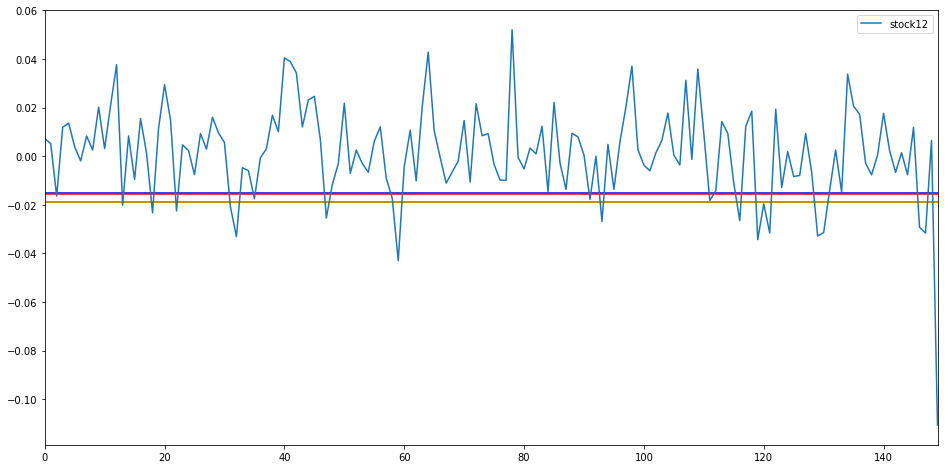

In [30]:
m = n.pop(0)
ret = df[wn_stocks[m]]

norm_fit = norm.fit(ret)

t_fit = t.fit(ret)

nct_fit = nct.fit(ret)

skewnorm_fit = skewnorm.fit(ret)

VaR_norm = norm.ppf(0.15, *norm_fit)
VaR_t = t.ppf(0.15, *t_fit)
VaR_nct = nct.ppf(0.15, *nct_fit)
VaR_skewnorm = skewnorm.ppf(0.15, *skewnorm_fit)
ax = ret.plot()
ax.hlines([VaR_norm, VaR_t, VaR_nct, VaR_skewnorm], xmin = 0, xmax=150, colors =['k', 'b', 'r', 'orange'])
ax.legend()
violation_norm = ret[ret<=VaR_norm].count()/len(ret)
violation_t = ret[ret<=VaR_t].count()/len(ret)
violation_nct = ret[ret<=VaR_nct].count()/len(ret)
violation_skewnorm = ret[ret<=VaR_skewnorm].count()/len(ret)


(violation_norm, violation_t,  violation_nct, violation_skewnorm) 

In [133]:
forecasts = {}

for s_name in wn_stocks:
    ret = df[s_name]
    nct_fit = nct.fit(ret)
    VaR_nct = nct.ppf(0.15, *nct_fit)
    forecasts[s_name] = pd.Series(10*[VaR_nct])

In [134]:
forecasts = pd.concat(forecasts, axis=1)

In [135]:
forecasts.to_csv('stocks_Strong_WN_VaR.csv')